## Import, Load, Explore Data

In [1]:
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.metrics import coverage_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [12]:
from __future__ import division

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
import warnings
import datetime

import string

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
SDG_dict = {1:"1: No Poverty", 
            2:"2: Zero Hunger",
            3:"3: Good Health and Well-being",
            4:"4: Quality Education",
            5:"5: Gender Equality",
            6:"6: Clean Water and Sanitation",
            7:"7: Affordable and Clean Energy",
            8:"8: Decent Work and Economic Growth",
            9:"9: Industry, Innovation, and Infrastructure",
            10:"10: Reduced Inequalities",
            11:"11: Sustainable Cities and Communities",
            12:"12: Responsible Consumption and Production",
            13:"13: Climate Action",
            14:"14: Life Below Water",
            15:"15: Life on Land",
            16:"16: Peace, Justice, and Strong Institutions",
            17:"17: Partnerships for the Goals"}

In [4]:
df_lab = pd.read_csv('manula_datakind_labels.csv')
df_lab = df_lab[['text', 'SDGs']]
for i in range(len(df_lab)):
    try: 
        df_lab['SDGs'][i] = df_lab['SDGs'][i].strip().split(", ")
    except:
        continue
        
df_lab = df_lab[df_lab['SDGs'].apply(type)==list]
df_lab.head()

,text,SDGs
0,Continue to work towards achieving gender equa...,[5]
1,"Ensure access to education, employment, health...","[8, 3, 4, 10]"
2,Enhance cooperation at the regional and intern...,"[1, 3, 2, 6]"
3,Continue the efforts undertaken by the Governm...,"[9, 16]"
4,"Improve equal access to the legal aid system, ...","[1, 10, 16]"


In [13]:
tfidf = TfidfVectorizer( max_df=.2, stop_words = text.ENGLISH_STOP_WORDS.union(string.punctuation),
                             tokenizer = word_tokenize)
X = tfidf.fit_transform(df_lab.text)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_lab.SDGs)


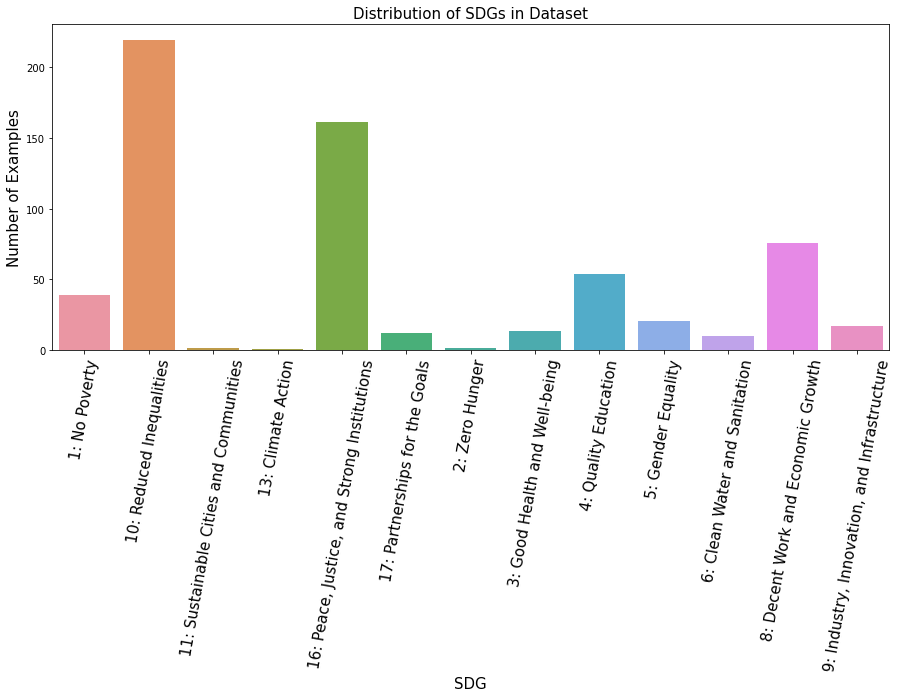

In [7]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=80, fontsize = 15)
plt.title('Distribution of SDGs in Dataset', fontsize = 15)
plt.ylabel('Number of Examples', fontsize = 15)
plt.xlabel('SDG', fontsize = 15)
sns.barplot([SDG_dict[int(i)] for i in list(mlb.classes_)], y.sum(axis=0))

In [8]:
# label cardinality is average number of labels per training example
df_lab['SDGs'].apply(len).mean()

1.7994269340974212

## Classifier Performance

In [9]:
dt = DecisionTreeClassifier()
mnb = OneVsRestClassifier(MultinomialNB())
rf = RandomForestClassifier()
svm = OneVsRestClassifier(LinearSVC())
knn = KNeighborsClassifier()
nn = MLPClassifier(activation='relu', solver ='adam', random_state=42, 
                  hidden_layer_sizes=(175,), max_iter=200,)

classifiers = {'tree': dt, 'naive bayes' :mnb, 'forest': rf, 'svm': svm, 'knn': knn, 'nn': nn}

In [10]:
def get_scores(metric):
    scores = dict()
    for clf_name, clf in classifiers.items():
        start = time.time()
        score = cross_val_score(clf, X, y, scoring=metric, cv=7)
        end = time.time()
        print(clf_name + " took %f seconds" % (end-start))
        scores[clf_name] = score
    
    return pd.DataFrame(scores)

tree took 0.284505 seconds
naive bayes took 0.164317 seconds
forest took 3.835855 seconds
svm took 0.160405 seconds
knn took 0.232150 seconds
nn took 17.752589 seconds


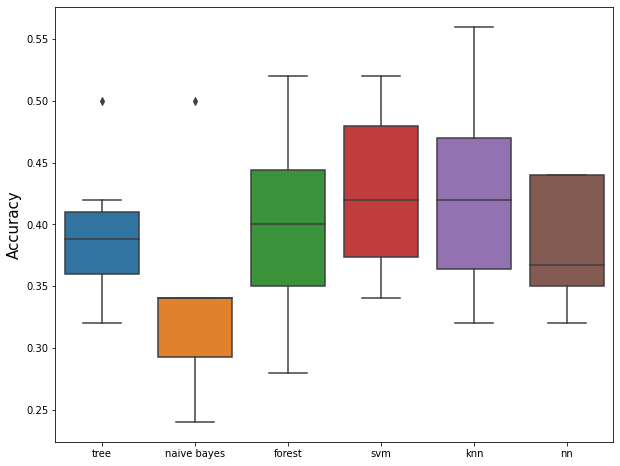

In [14]:
plt.figure(figsize=(10,8))
plt.ylabel('Accuracy', fontsize=15)
sns.boxplot(data=get_scores('accuracy'))

tree took 0.246229 seconds
naive bayes took 0.150553 seconds
forest took 2.939364 seconds
svm took 0.155073 seconds
knn took 0.189425 seconds
nn took 15.047411 seconds


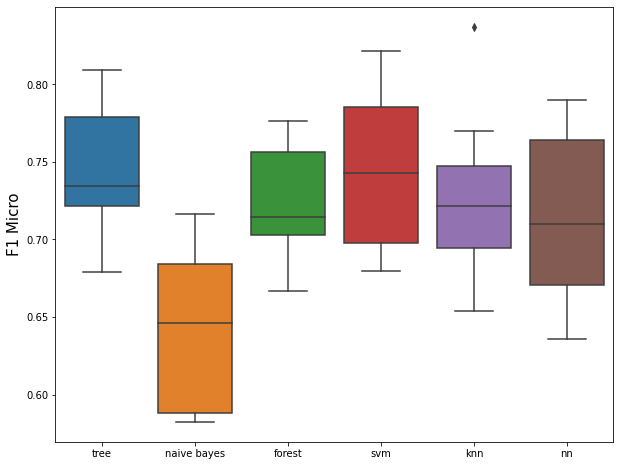

In [15]:
plt.figure(figsize=(10,8))
plt.ylabel('F1 Micro', fontsize=15)
sns.boxplot(data=get_scores('f1_micro'))

## Let's try to predict some text with our decision tree classifier

In [17]:
def predict_SDG(text, model):
    test = tfidf.transform([text])
    model.fit(X,y)
    preds = model.predict(test)
    SDGs= zip(preds[0], [SDG_dict[int(i)] for i in list(mlb.classes_)])
    return [desc for num, desc in SDGs if num == 1]
    

In [18]:
acore = "ACORE is a national non-profit organization dedicated to advancing the renewable energy sector through market development, policy changes, and financial innovation. With a savvy staff of experts, fifteen years of experience promoting renewable energy and hundreds of member companies, non-profits, and other organizations from across the spectrum of renewable energy technologies, consumers, and investors, ACORE is uniquely well-positioned to strategically promote the policies and financial structures essential to renewable energy growth. The organization’s annual conferences in Washington, D.C., New York and San Francisco set the industry standard in providing important venues for key leaders to meet, discuss recent developments, and hear the latest from senior government officials and seasoned experts. ACORE's membership spans all constituencies in the renewable energy sector, including developers, manufacturers, providers of smart grid technologies, financial institutions, corporate end-users, professional service providers, educators, and allied non-profit groups. ACORE accomplishes much of its work by convening leaders in each of these constituencies, publishing research and analysis, advocating for key policies with Federal and state legislators and agency officials, facilitating communications among our members, and media outreach."

In [19]:
predict_SDG(acore, dt)

['9: Industry, Innovation, and Infrastructure']

OK, the ACORE text came up as SDG 9 when we use the decision tree model:
<p>Not wrong, but not right

In [20]:
msfgoals = "Médecins Sans Frontières is a private, international association. The association is made up mainly of doctors and health sector workers and is also open to all other professions which might help in achieving its aims. All of its members agree to honour the following principles: Médecins Sans Frontières provides assistance to populations in distress, to victims of natural or man-made disasters and to victims of armed conflict. They do so irrespective of race, religion, creed or political convictions. Médecins Sans Frontières observes neutrality and impartiality in the name of universal medical ethics and the right to humanitarian assistance and claims full and unhindered freedom in the exercise of its functions. Members undertake to respect their professional code of ethics and maintain complete independence from all political, economic or religious powers. As volunteers, members understand the risks and dangers of the missions they carry out and make no claim for themselves or their assigns for any form of compensation other than that which the association might be able to afford them."

In [21]:
predict_SDG(msfgoals, svm)

['10: Reduced Inequalities']

MSFGOALS text came up as SDG 10 when we use the support vector machine:

<p>MSFGOALS is primarily about health and medicine, so this is not a very good match

## Evaluation

In [22]:
# 80/20 train test split
train_split = int(X.shape[0]*.8)
dt.fit(X[:train_split],y[:train_split])
y_pred = dt.predict(X[(train_split+1):])
y_true = y[(train_split+1):]

print(y_true.shape)
print(y_pred.shape)

(69, 13)
(69, 13)


In [23]:
from sklearn.metrics import label_ranking_average_precision_score
label_ranking_average_precision_score(y_true, y_pred)

0.591075188901276

In [24]:
true_predicted_diff = (y_true.sum(axis=0) - y_pred.sum(axis=0))
true_predicted_diff_norm = true_predicted_diff / y_true.sum(axis=0)

Aggregate difference between true and predicted labels. Score of 0 indicates that there are either no wrong predictions or the false positives and false negatives cancel out.


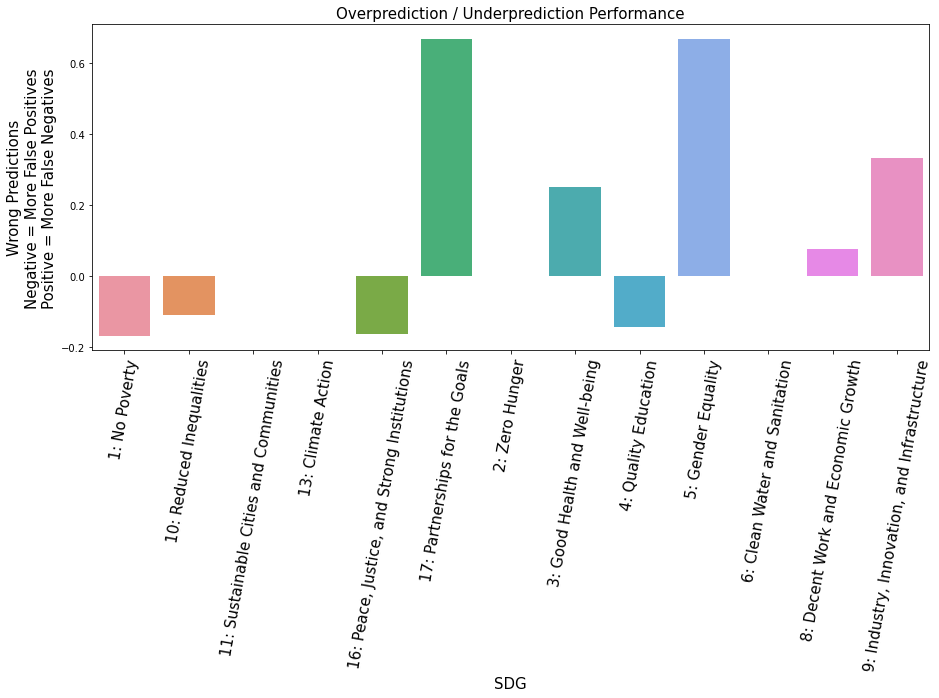

In [25]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=80, fontsize = 15)
plt.title('Overprediction / Underprediction Performance', fontsize = 15)
plt.ylabel('Wrong Predictions\nNegative = More False Positives\nPositive = More False Negatives', fontsize = 15)
plt.xlabel('SDG', fontsize = 15)
sns.barplot([SDG_dict[int(i)] for i in list(mlb.classes_)], true_predicted_diff_norm)
print("Aggregate difference between true and predicted labels. Score of 0 indicates that there are either no wrong predictions or the false positives and false negatives cancel out.")

In [26]:
# plot confusion matrix 
def plot_confusion_matrix(cm_normalized, i):
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    title = "SDG "+ SDG_dict[int(mlb.classes_[i])]+ "\nNumber of Occurences = %i" % y_true[:,i].sum(axis=0)
    plt.title(title, fontsize=17)
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()

Confusion matrix:
 [[60  3]
 [ 2  4]]


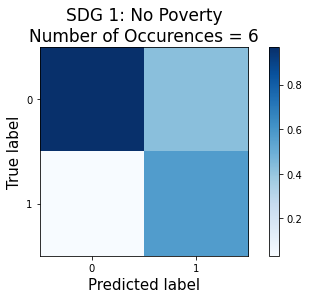

Confusion matrix:
 [[11 12]
 [ 7 39]]


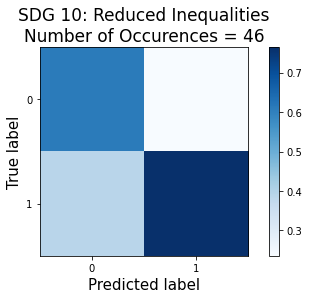

Confusion matrix:
 [[69]]


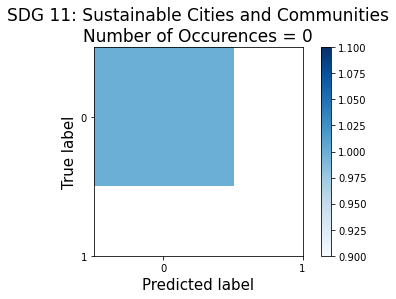

Confusion matrix:
 [[69]]


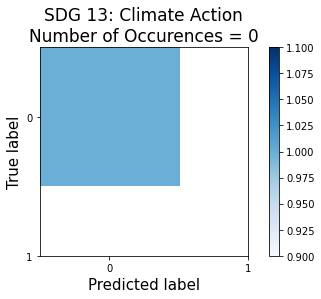

Confusion matrix:
 [[23 15]
 [10 21]]


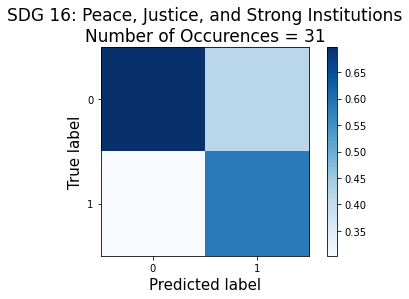

Confusion matrix:
 [[66  0]
 [ 2  1]]


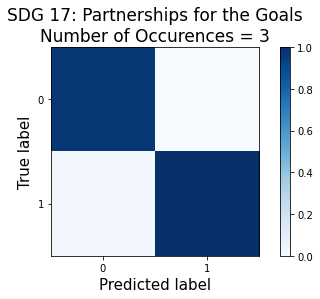

Confusion matrix:
 [[69]]


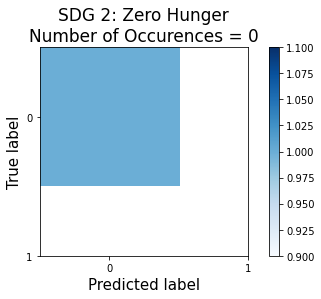

Confusion matrix:
 [[62  3]
 [ 4  0]]


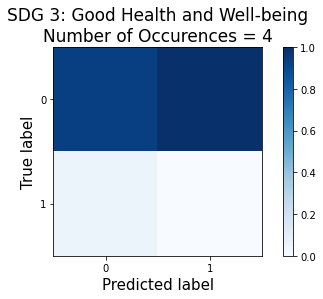

Confusion matrix:
 [[60  2]
 [ 1  6]]


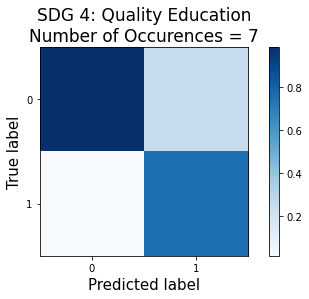

Confusion matrix:
 [[63  0]
 [ 4  2]]


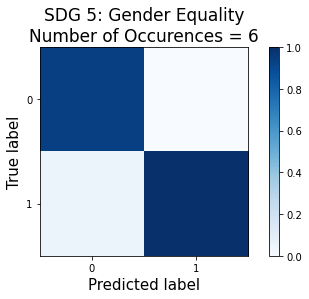

Confusion matrix:
 [[68  0]
 [ 0  1]]


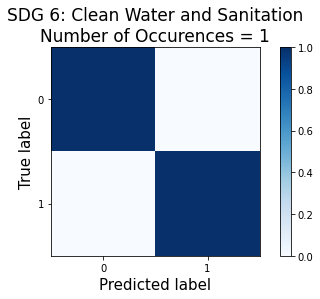

Confusion matrix:
 [[51  5]
 [ 6  7]]


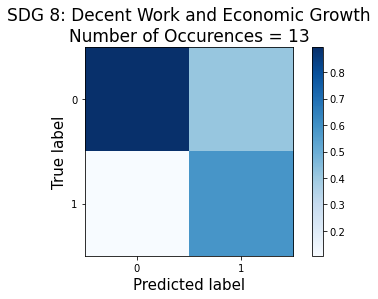

Confusion matrix:
 [[65  1]
 [ 2  1]]


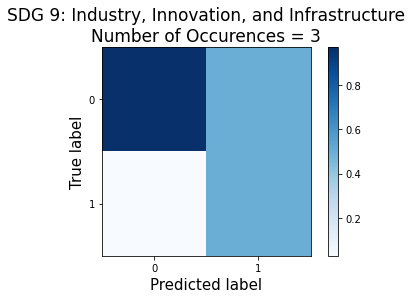

In [27]:
for ind, val in enumerate(mlb.classes_):
    cm = confusion_matrix(y_true[:,ind], y_pred[:,ind])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    print("Confusion matrix:\n", cm)
    plot_confusion_matrix(cm_normalized, ind)